# DOE 本番解析用 (base) v4

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [5]:
name_doe = "doe-10b"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join("..", "output", name_doe, f"y{m.group(1)}", m.group(2))
    date_str = os.path.join(date_dir, m.group(3))
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00")
    date_str = os.path.join(date_dir, "00")
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

## CSV ファイルの読み込み、連結

In [6]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_latest_single.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20250819.xlsx  7011    100  1000.0           30          300
1    ticks_20250819.xlsx  7011    100  2700.0           40          300
2    ticks_20250819.xlsx  7011     80 -1900.0           50          300
3    ticks_20250819.xlsx  7011     70 -5200.0           60          300
4    ticks_20250819.xlsx  7011     48  1500.0           70          300
..                   ...   ...    ...     ...          ...          ...
284  ticks_20250819.xlsx  7011      8  4900.0          150         1100
285  ticks_20250819.xlsx  7011      4  2100.0          160         1100
286  ticks_20250819.xlsx  7011      4  2100.0          170         1100
287  ticks_20250819.xlsx  7011      4  -700.0          180         1100
288  ticks_20250819.xlsx  7011      2  3600.0          190         1100

[289 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade   total  PERIOD_MA_1  PE

### 本日の条件

In [7]:
x_por = 60
y_por = 600
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考
105           60          600    42 -1400.0   


## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

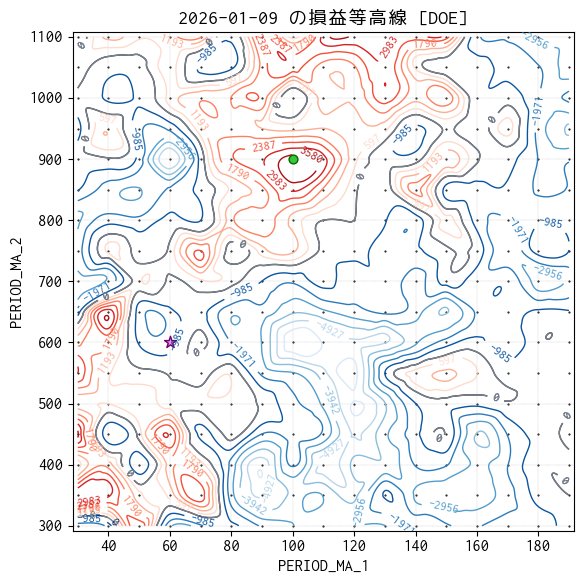

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = f"{date_str}_{name_code}_contour_single.png"

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

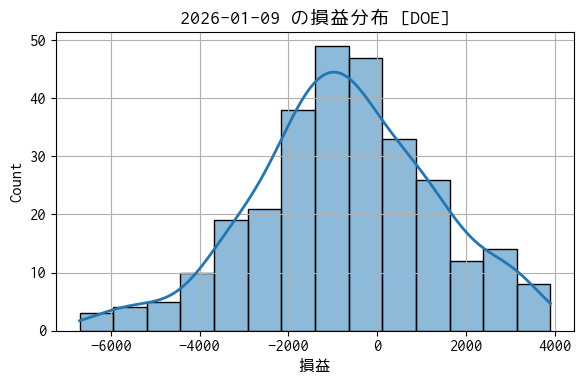

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [DOE]")

plt.tight_layout()
output = f"{date_str}_{name_code}_hist_single.png"
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                     file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
9633  ticks_20251007.xlsx  7011     22  32400.0          140          550

最低損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
10785  ticks_20251014.xlsx  7011     90 -20200.0          100          550


## サマリ統計の算出

In [12]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = (
    df_summary.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)

html = styled.to_html()
output = f"{date_str}_{name_code}_summary.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade       total
0             30          300  99.479167 -708.333333
1             40          300  94.291667 -677.083333
2             50          300  82.333333 -832.291667
3             60          300  68.895833 -696.875000
4             70          300  60.229167 -662.500000
..           ...          ...        ...         ...
284          150         1100  11.854167  316.666667
285          160         1100  10.729167   17.708333
286          170         1100   9.500000    0.000000
287          180         1100   8.625000  -81.250000
288          190         1100   8.083333   -6.250000

[289 rows x 4 columns]


## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5        6       7    \
2025-08-19  1000.0  2700.0 -1900.0 -5200.0  1500.0  4200.0   2800.0 -3200.0   
2025-08-20  4000.0  2900.0  6700.0  3100.0  5000.0  6500.0   7200.0  6400.0   
2025-08-21  1700.0  -300.0  4000.0  4900.0  5100.0  4300.0    600.0  1300.0   
2025-08-22 -7300.0 -3900.0 -4800.0  -400.0 -2600.0  -400.0    600.0   500.0   
2025-08-25 -3400.0 -2100.0 -1300.0 -2400.0 -1700.0 -1400.0  -1000.0 -1100.0   
...            ...     ...     ...     ...     ...     ...      ...     ...   
2026-01-05  2900.0  4100.0  5600.0 -1800.0  2500.0  4600.0   3300.0  3800.0   
2026-01-06  5500.0  3000.0  3600.0  1200.0  3800.0   500.0  -4700.0 -2600.0   
2026-01-07  5000.0  5800.0  9900.0  6700.0  4800.0  1200.0   -100.0   100.0   
2026-01-08 -3300.0 -2000.0 -6800.0 -6300.0 -4000.0 -8000.0 -13000.0 -9600.0   
2026-01-09 -2700.0 -1500.0  2900.0 -2700.0 -2200.0  -800.0  -2100.0 -2900.0   

                8       9    ..

## 平均損益の算出

In [14]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-09, n = 96 days

df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                    0            1            2            3            4    \
2025-08-19  1000.000000  2700.000000 -1900.000000 -5200.000000  1500.000000   
2025-08-20  2500.000000  2800.000000  2400.000000 -1050.000000  3250.000000   
2025-08-21  2233.333333  1766.666667  2933.333333   933.333333  3866.666667   
2025-08-22  -150.000000   350.000000  1000.000000   600.000000  2250.000000   
2025-08-25  -800.000000  -140.000000   540.000000     0.000000  1460.000000   
...                 ...          ...          ...          ...          ...   
2026-01-05  -788.043478  -764.130435  -972.826087  -715.217391  -717.391304   
2026-01-06  -720.430108  -723.655914  -923.655914  -694.623656  -668.817204   
2026-01-07  -659.574468  -654.255319  -808.510638  -615.957447  -610.638298   
2026-01-08  -687.368421  -668.421053  -871.578947  -675.789474  -646.315789   
2026-01-09  -708.333333  -67

### 検算

In [15]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト損益

In [16]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[str(dt_last.date())]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高損益条件")
print(df_last_max)

最終日 (2026-01-09) の最高損益条件
     PERIOD_MA_1  PERIOD_MA_2      損益
211        100.0        900.0  3900.0


## ランキング

In [17]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col
# dt_last = df_raw.index[-1]
# ser_best_last = df_raw.loc[dt_last][best_conditions]
# df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "平均損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_best.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col
# dt_last = df_raw.index[-1]
# ser_negative_last = df_raw.loc[dt_last][negative_conditions]
# df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2       取引回数         平均損益
96          140          550  17.958333  1152.083333
81          160          500  14.625000  1022.916667
82          170          500  13.041667  1013.541667
65          170          450  13.812500   962.500000
46          150          400  17.729167   961.458333
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数         平均損益
288          190         1100   8.083333    -6.250000
245          100         1000  21.104167   -10.416667
215          140          900  14.708333   -13.541667
233          150          950  13.083333   -13.541667
172           50          800  53.437500   -20.833333
..           ...          ...        ...          ...
52            40          450  86.520833  -879.166667
204           30          900  80.208333  -968.750000
19            50          350  78.375000 -1009.375000
272           30         1100  74.750000 -1015.625000
256           40         1050  59.125000 -102

## 実験条件毎の損益トレンド

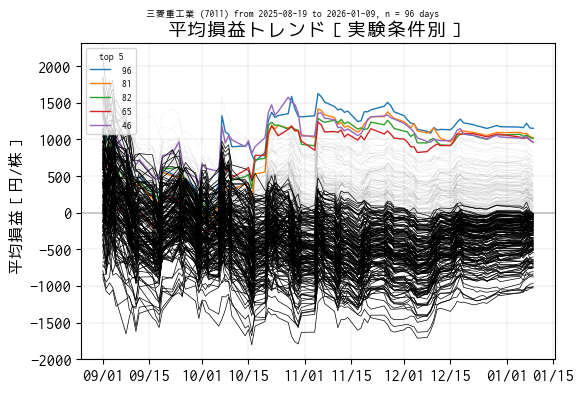

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title("平均損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = f"{date_str}_{name_code}_trend_mean_profit_{target}.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ損益条件 (mean) の日別損益トレンド

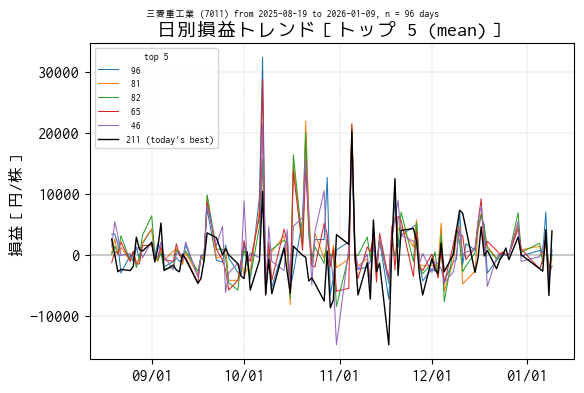

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title("日別損益トレンド［トップ 5 (mean)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = f"{date_str}_{name_code}_trend_daily_profit_1.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

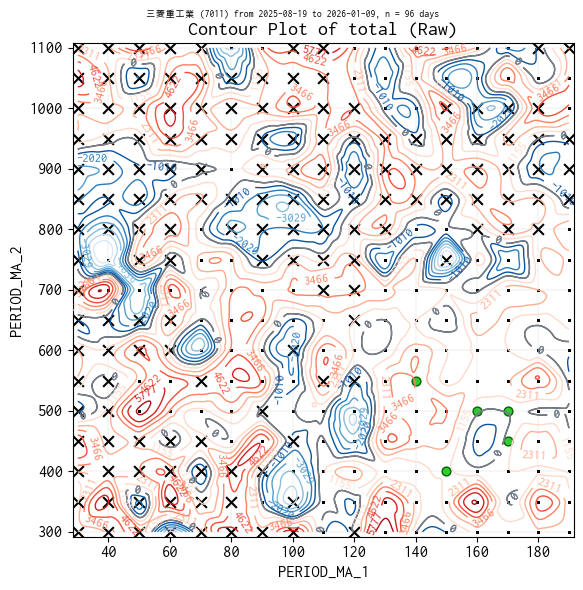

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
# cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
# ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = f"{date_str}_{name_code}_raw_contour_{target}.png"
plt.savefig(output)
plt.show()

## メディアン損益の算出

In [21]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-09, n = 96 days


In [22]:
n = len(df_median.index)

In [23]:
df_median[:n].median()

0      -900.0
1     -1150.0
2     -1100.0
3     -1050.0
4     -1150.0
        ...  
284    -300.0
285    -700.0
286    -500.0
287    -400.0
288       0.0
Length: 289, dtype: float64

In [24]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン損益を算出")
print(df_median)

# 最終日の損益収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン損益を算出
               0       1       2       3       4       5       6       7    \
2025-08-19  1000.0  2700.0 -1900.0 -5200.0  1500.0  4200.0  2800.0 -3200.0   
2025-08-20  2500.0  2800.0  2400.0 -1050.0  3250.0  5350.0  5000.0  1600.0   
2025-08-21  1700.0  2700.0  4000.0  3100.0  5000.0  4300.0  2800.0  1300.0   
2025-08-22  1350.0  1200.0  1050.0  1350.0  3250.0  4250.0  1700.0   900.0   
2025-08-25  1000.0  -300.0 -1300.0  -400.0  1500.0  4200.0   600.0   500.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-05  -900.0 -1150.0 -1150.0 -1050.0 -1150.0 -1400.0  -900.0  -600.0   
2026-01-06  -900.0 -1100.0 -1100.0 -1000.0 -1100.0 -1400.0  -900.0  -600.0   
2026-01-07  -800.0 -1100.0 -1100.0  -950.0 -1100.0 -1350.0  -900.0  -600.0   
2026-01-08  -900.0 -1100.0 -1100.0 -1000.0 -1100.0 -1400.0  -900.0  -600.0   
2026-01-09  -900.0 -1150.0 -1100.0 -1050.0 -1150.0 -1350.0  -950.0  -600.0   

               8       9 

## サマリ統計（メディアン）

In [25]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade   total
0             30          300  100.0  -900.0
1             40          300  100.0 -1150.0
2             50          300   89.0 -1100.0
3             60          300   70.0 -1050.0
4             70          300   60.0 -1150.0
..           ...          ...    ...     ...
284          150         1100   12.0  -300.0
285          160         1100   10.0  -700.0
286          170         1100    8.0  -500.0
287          180         1100    8.0  -400.0
288          190         1100    8.0     0.0

[289 rows x 4 columns]


### 検算

In [26]:
"""
サマリ統計 (df_summary) の平均値と、算出したメジアン損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [27]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col
# dt_last = df_raw.index[-1]
# ser_best_last = df_raw.loc[dt_last][best_conditions]
# df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "メジアン損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_best_median.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col
# dt_last = df_raw.index[-1]
# ser_negative_last = df_raw.loc[dt_last][negative_conditions]
# df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
143          100          700  24.0   850.0
124           80          650  36.0   600.0
45           140          400  18.0   400.0
30           160          350  14.0   350.0
123           70          650  40.0   300.0
12           150          300  15.0   300.0
82           170          500  12.0   200.0
108           90          600  30.0   200.0
90            80          550  37.0   200.0
139           60          700  48.0   200.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
182          150          800  13.0   -50.0
16           190          300  10.0   -50.0
270          180         1050   8.0   -50.0
169          190          750   9.0   -50.0
150          170          700  12.0   -50.0
..           ...          ...   ...     ...
19            50          350  81.0 -1350.0
22            80          350  50.0 -1350.0
204           30          900  80.0 -1400.0
256           40         1050  57

## 実験条件毎の収益トレンド（メジアン）

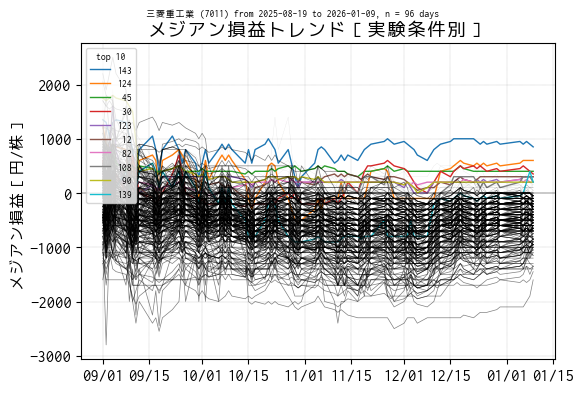

In [28]:
# ---------------------------------------------------------
# 実験条件毎のメジアン損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title("メジアン損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = f"{date_str}_{name_code}_trend_median_profit_{target}.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別損益トレンド

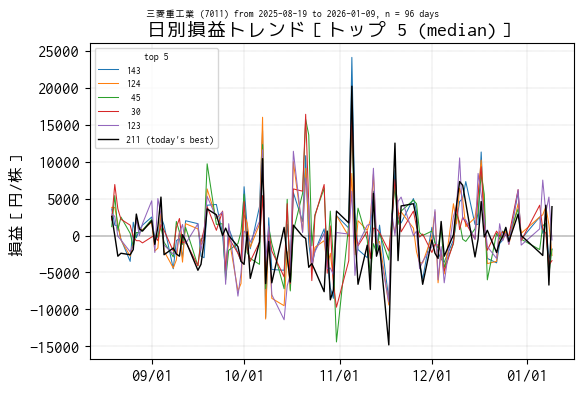

In [29]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title("日別損益トレンド［トップ 5 (median)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = f"{date_str}_{name_code}_trend_daily_profit_2.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()